# Project: Multiclass Classification with HCV Dataset

*By Daniel Deutsch, José Lucas Barretto, Kevin kühl and Lucas Miguel Agrizzi*

In [2]:
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import optimizers
from keras.callbacks import EarlyStopping
from pprint import pprint

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Data Representation

Here, we are going to read the dataset and represent it in the best way possible for running our analysis.

In [4]:
# Reads the dataset
df = pd.read_csv("./datasets/hcv.csv", index_col=0)
df.dropna(inplace=True)

# Numericalyze columns
df['Sex'] = df['Sex'].apply(lambda x: x == 'm').astype(int)

# Separates the covariates from the labels
X = df[df.columns.difference(['Category'])].values
y = df['Category'].values

# Label encode categories in label data
label_enc = LabelEncoder()
y = label_enc.fit_transform(y)

# Splits data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize covariates
X_scaler = StandardScaler()
X_train_normal = X_scaler.fit_transform(X_train)
X_test_normal = X_scaler.transform(X_test)

# Create dict for results
results = {}

# Exploratory Data Analysis

### Percentage of Pacients by Diagnosis

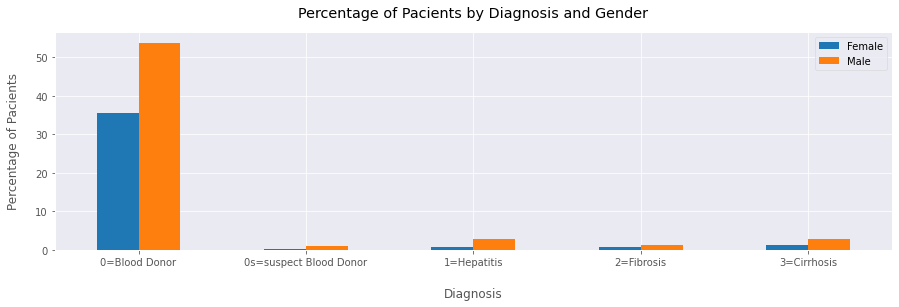

In [5]:
fig, ax = plt.subplots()

df_grouped = (df[['Category', 'Sex', 'Age']].groupby(['Category', 'Sex']).count()*100/len(df)).unstack(level=1)

df_grouped.plot.bar(
    color=['tab:blue', 'tab:orange'],
    legend=True,
    ax=ax
)

ax.legend(['Female', 'Male'])
ax.set_xlabel('Diagnosis', labelpad=20)
ax.set_ylabel('Percentage of Pacients', labelpad=15)

plt.xticks(rotation='horizontal')
plt.title('Percentage of Pacients by Diagnosis and Gender', pad=15)
plt.show()

This plot shows us that our dataset is relatively unbalanced, since we have a majority of labels classified as '0=Blood Donor'. This can cause some trouble while fitting the models, since it is easy for the training to be biased to always predict class 0 (because it represents the large majority of labels). Another problem is that we have very few samples for some types of diagnosis, which means that they are severely underrepresented in the dataset.

### Visualizing Correlations Between Variables

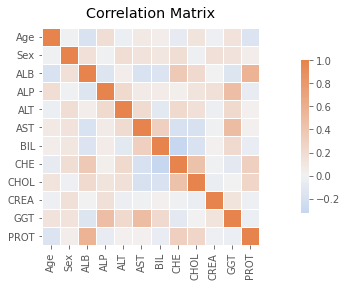

In [6]:
fig, ax = plt.subplots()

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(250, 30, l=65, as_cmap=True)

sns.heatmap(
    corr,
    square=True,
    #mask=mask,
    linewidths=.5,
    cbar_kws={"shrink": 0.7},
    center=0,
    cmap=cmap,
    ax=ax
)

ax.set_title('Correlation Matrix', pad=10)
plt.show()

We can see that most covariates have relatively low levels of correlation. Therefore, we will not try some type of dimensionality reduction, because our feature space has a low dimensionality and covariates have low correlations, hence performance gains are not expected when using such methods.

# Support Vector Machine Analysis

In [7]:
# Find the best parameters with 5-fold cross-validation

# Generate cross validation sets
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)

# Generate hyperparameters spaces
C = np.logspace(1, 2, 20)
gammas = np.logspace(-3, -1, 20)

# Linear search for best hyper parameters
best_score = 0
for _,(c, gamma) in enumerate(it.product(C, gammas)):
    
    model = svm.SVC(kernel='rbf', C=c, gamma=gamma)
    
    # Evaluate model
    scores = cross_val_score(model, X_train_normal, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    
    if score > best_score:
        best_score = score
        C_opt = c
        gamma_opt = gamma

# Print results
print('SVM Results:')
print('Best Validation Accuracy:', round(100*best_score, 3), '%')
print('Optimal Params - C:', round(C_opt, 3), ', Gamma:', round(gamma_opt, 3))

SVM Results:
Best Validation Accuracy: 95.626 %
Optimal Params - C: 10.0 , Gamma: 0.023


In [8]:
# Test model with optimum parameters
model = svm.SVC(kernel='rbf', C=C_opt, gamma=gamma_opt)
model.fit(X_train_normal, y_train)
SVM_score = model.score(X_test_normal, y_test)

results['SVM'] = {
    'score': SVM_score,
    'params': {'C': C_opt, 'gamma': gamma_opt}
}

print('SVM Test Score:', round(100*SVM_score, 5), '%')

SVM Test Score: 92.65537 %


# Tree Analysis

### Bagging Decision Trees

In [9]:
# Apply cross-validation to optimimze decision tree hyperparams

# Generate cross validation sets
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)

# Generate hyperparameters spaces
depths = [10, 50, 100, 200, 500, None]

# Linear search for best hyper parameters
best_score = 0
for _,(depth) in enumerate(depths):
    
    # Create model
    model = DecisionTreeClassifier(max_depth = depth)
    
    # Evaluate model
    scores = cross_val_score(model, X_train_normal, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    
    if score > best_score:
        best_score = score
        depth_opt = depth

# Print results
print('Decision Tree Results:')
print('Best Validation Accuracy:', round(100*best_score, 3), '%')
print('Optimal Params - Max depth:', round(depth_opt, 3))

Decision Tree Results:
Best Validation Accuracy: 93.441 %
Optimal Params - Max depth: 100


In [10]:
# Bagging Decision Trees

n_estimators = np.arange(1, 1000, 50)

# Generate cross validation sets
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)
val_scores = []
for n in n_estimators:
    
    # Create model
    bagging_model = BaggingClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=depth_opt),
        n_estimators=n,
        random_state=0
    ).fit(X_train_normal, y_train)
    
    # Evaluate model
    scores = cross_val_score(bagging_model, X_train_normal, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    val_scores.append(score)

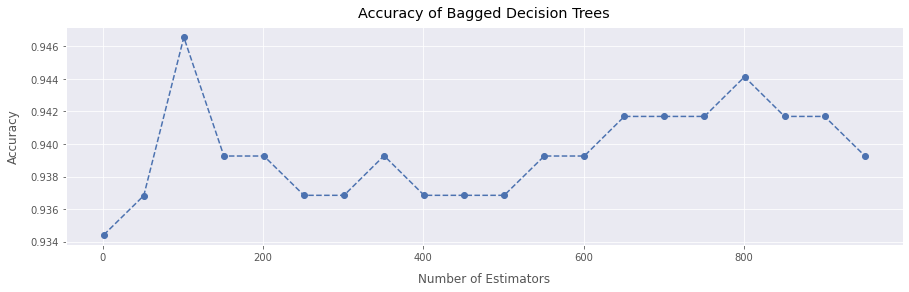

In [11]:
plt.figure()
plt.title('Accuracy of Bagged Decision Trees', pad=10)
plt.xlabel('Number of Estimators', labelpad=10)
plt.ylabel('Accuracy', labelpad=10)
plt.plot(n_estimators, val_scores, '--o')
plt.show()

We can see that in the range between 300-500 estimators, the bagged models present consistently high validation scores. For this reason, we will chose n_estimators = 400 and calculate the test score.

In [12]:
# Test model with optimum parameters

bagging_model = BaggingClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=depth),
        n_estimators=400,
        random_state=0
    ).fit(X_train_normal, y_train)
bagging_trees_score = bagging_model.score(X_test_normal, y_test)

results['Bagging Trees'] = {
    'score': bagging_trees_score,
    'params': {'n_estimators': 400, 'max_depth': depth_opt}
}

print('Bagging Trees Test Score:', round(100*bagging_trees_score, 5), '%')

Bagging Trees Test Score: 90.39548 %


### Random Forests

In [13]:
# Randomized search CV for best Random Forest hyperparameters

# Number of estimators
n_estimators = np.arange(10, 500, 50).tolist()

# Max number of features
max_features = ['auto', 'sqrt']

# Max depth of trees
max_depth = np.arange(50, 150, 10).tolist()
max_depth.append(None)

# Create random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth
}

# Define model
model = RandomForestClassifier()

# Run randomized CV
model_cv = RandomizedSearchCV(
    estimator = model,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3, 
    verbose=10,
    n_jobs = -1
).fit(X_train_normal, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
C:\Users\Dell\Desktop\Code\Telecom\2A\P3\SD-TSIA210\project\binary\venv\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


In [14]:
# Print results
print('Random Forest Results:')
print('Best Validation Accuracy:', round(100*model_cv.best_score_, 3), '%')
print(
    'Optimal Params - n_estimators:', model_cv.best_params_['n_estimators'],
    ', max_features:', model_cv.best_params_['max_features'],
    ', max_depth:', model_cv.best_params_['max_depth']
)

Random Forest Results:
Best Validation Accuracy: 95.874 %
Optimal Params - n_estimators: 60 , max_features: sqrt , max_depth: 110


In [15]:
# Test model with optimum parameters

RF_model = model_cv.best_estimator_
RF_model.fit(X_train_normal, y_train)
RF_score = RF_model.score(X_test_normal, y_test)

results['Random Forest'] = {
    'score': RF_score,
    'params': {
        'n_estimators': model_cv.best_params_['n_estimators'],
        'max_features': model_cv.best_params_['max_features'],
        'max_depth': model_cv.best_params_['max_depth']}
}

print('Random Forest Test Score:', round(100*RF_score, 5), '%')

Random Forest Test Score: 89.83051 %


# Neural Network Analysis

In [16]:
# Prepare data for Neural Network Models

# OH encode categories in label data
OH_enc = OneHotEncoder(handle_unknown='ignore')
OH_enc.fit(y.reshape(-1, 1))
y_train_OH = OH_enc.transform(y_train.reshape(-1, 1)).toarray()
y_test_OH = OH_enc.transform(y_test.reshape(-1, 1)).toarray()

# Define shapes
input_shape = X_train_normal.shape[1]
n_labels = len(np.unique(y))

### One-Layer Network

In [17]:
# Define One-Layer NN
one_layer_nn_model = Sequential([
    Dense(300, input_shape=(input_shape,), activation='relu'),
    Dense(n_labels, activation='softmax')
])

# Define optimizer - SGD with Momentum
opt = optimizers.SGD(learning_rate=0.01, momentum=0.08)

# Compile model
one_layer_nn_model.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# Train the model with early stopping;
epochs = 1000
early_stop = EarlyStopping(monitor='val_loss', patience=15)

history = one_layer_nn_model.fit(
    X_train_normal, y_train_OH,
    batch_size = 128,
    epochs = epochs,
    verbose = 1,
    validation_split = 0.33,
    callbacks = [early_stop]
)

Epoch 861/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0540 - accuracy: 0.9841 - val_loss: 0.1191 - val_accuracy: 0.9485
Epoch 862/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0599 - accuracy: 0.9822 - val_loss: 0.1191 - val_accuracy: 0.9485
Epoch 863/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0548 - accuracy: 0.9841 - val_loss: 0.1191 - val_accuracy: 0.9485
Epoch 864/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0537 - accuracy: 0.9861 - val_loss: 0.1191 - val_accuracy: 0.9485
Epoch 865/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0612 - accuracy: 0.9782 - val_loss: 0.1190 - val_accuracy: 0.9485
Epoch 866/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0588 - accuracy: 0.9802 - val_loss: 0.1190 - val_accuracy: 0.9485
Epoch 867/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0587 - accuracy: 0.9802 - val_loss: 0.1189 - val_accuracy: 0.9485

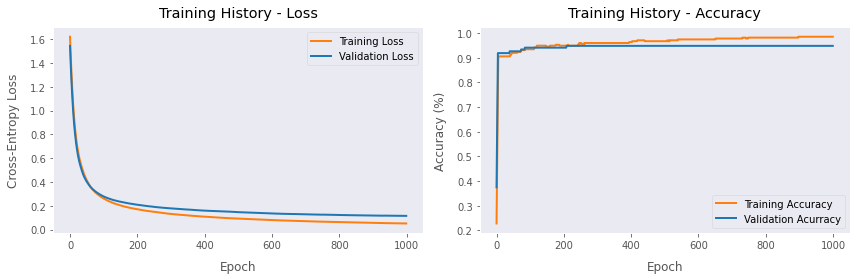

In [18]:
# Plot training curves

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(hist['loss'], c='tab:orange', lw=2)
ax[0].plot(hist['val_loss'], c='tab:blue', lw=2)
ax[0].legend(['Training Loss', 'Validation Loss'])
ax[0].set_xlabel('Epoch', labelpad=10)
ax[0].set_ylabel('Cross-Entropy Loss', labelpad=10)
ax[0].set_title('Training History - Loss', pad=10)
ax[0].grid(alpha=0.6)

ax[1].plot(hist['accuracy'], c='tab:orange', lw=2)
ax[1].plot(hist['val_accuracy'], c='tab:blue', lw=2)
ax[1].legend(['Training Accuracy', 'Validation Acurracy'])
ax[1].set_xlabel('Epoch', labelpad=10)
ax[1].set_ylabel('Accuracy (%)', labelpad=10)
ax[1].set_title('Training History - Accuracy', pad=10)
ax[1].grid(alpha=0.6)

plt.tight_layout()
plt.show()

In [19]:
# Test One-Layer NN Model

one_layer_nn_score = one_layer_nn_model.evaluate(X_test_normal, y_test_OH, verbose=0)

results['One-Layer NN'] = {
    'score': one_layer_nn_score[1]
}

print('One-Layer NN Test Score:', round(100*one_layer_nn_score[1], 5), '%')

One-Layer NN Test Score: 90.39548 %


### Multilayer Perceptron

In [20]:
# Define MLP NN
mlp_model = Sequential([
    Dense(300, input_shape=(input_shape,), activation='relu'),
    Dense(180, input_shape=(input_shape,), activation='relu'),
    Dense(n_labels, activation='softmax')
])

# Define optimizer - SGD with Momentum
opt = optimizers.SGD(learning_rate=0.01, momentum=0.8)

# Compile model
mlp_model.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# Train the model with early stopping;
epochs = 1000
early_stop = EarlyStopping(monitor='val_loss', patience=15)

history = mlp_model.fit(
    X_train_normal, y_train_OH,
    batch_size = 128,
    epochs = epochs,
    verbose = 1,
    validation_split = 0.33,
    callbacks = [early_stop]
)

.9485
Epoch 91/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0756 - accuracy: 0.9776 - val_loss: 0.1344 - val_accuracy: 0.9485
Epoch 92/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0754 - accuracy: 0.9776 - val_loss: 0.1340 - val_accuracy: 0.9412
Epoch 93/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0743 - accuracy: 0.9756 - val_loss: 0.1321 - val_accuracy: 0.9412
Epoch 94/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0722 - accuracy: 0.9776 - val_loss: 0.1293 - val_accuracy: 0.9412
Epoch 95/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0770 - accuracy: 0.9746 - val_loss: 0.1274 - val_accuracy: 0.9412
Epoch 96/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0787 - accuracy: 0.9794 - val_loss: 0.1266 - val_accuracy: 0.9485
Epoch 97/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0726 - accuracy: 0.9774 - val_loss: 0.1262 - val_accuracy: 0.9485
E

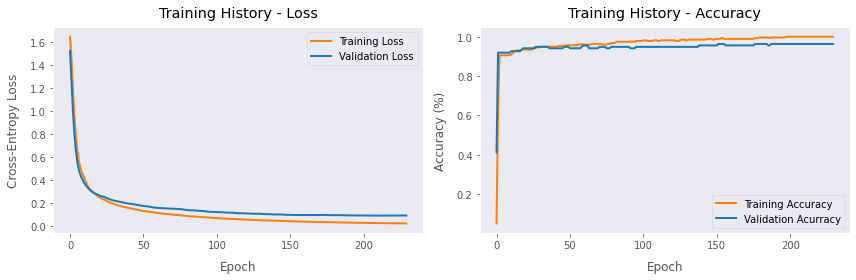

In [21]:
# Plot training curves

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(hist['loss'], c='tab:orange', lw=2)
ax[0].plot(hist['val_loss'], c='tab:blue', lw=2)
ax[0].legend(['Training Loss', 'Validation Loss'])
ax[0].set_xlabel('Epoch', labelpad=10)
ax[0].set_ylabel('Cross-Entropy Loss', labelpad=10)
ax[0].set_title('Training History - Loss', pad=10)
ax[0].grid(alpha=0.6)

ax[1].plot(hist['accuracy'], c='tab:orange', lw=2)
ax[1].plot(hist['val_accuracy'], c='tab:blue', lw=2)
ax[1].legend(['Training Accuracy', 'Validation Acurracy'])
ax[1].set_xlabel('Epoch', labelpad=10)
ax[1].set_ylabel('Accuracy (%)', labelpad=10)
ax[1].set_title('Training History - Accuracy', pad=10)
ax[1].grid(alpha=0.6)

plt.tight_layout()
plt.show()

In [22]:
# Test MLP NN Model

mlp_score = mlp_model.evaluate(X_test_normal, y_test_OH, verbose=0)

results['MLP'] = {
    'score': mlp_score[1]
}

print('MLP Test Score:', round(100*mlp_score[1], 5), '%')

MLP Test Score: 90.96045 %


While experimenting with the Network's architecture, it is possible to see that increasing the number of layers does not contribute significantly to the model's performance. This can be due to the fact that the Network is too complex for the modeled data. For this reason, we decided to keep the architecture simple, with only 2 layers.

# Method Comparison and Analysis

First, let's compare the different accuracy results for each model applied:

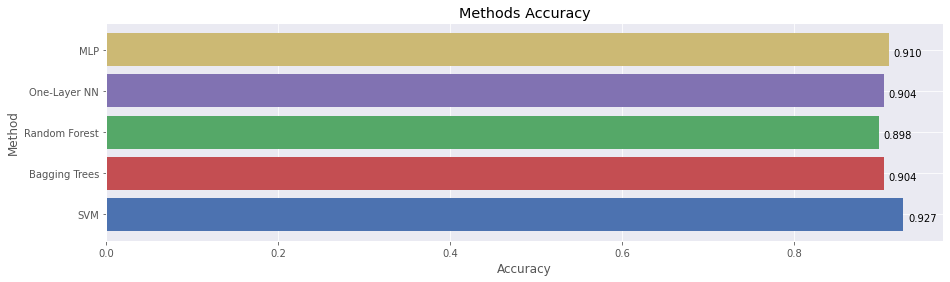

In [29]:
for key, val in results.items():
    plt.barh(key, val['score'])
for p in plt.gca().patches:
    plt.gca().annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')

plt.title('Methods Accuracy')
plt.ylabel('Method')
plt.xlabel('Accuracy')
plt.show()

We can see that most models performed well, achieving accuracy levels of over 90%. Since we used cross-validation or early stopping techniques for every model, we avoided overfitting of the results. We can see that the SVM had the best performance on classifying the data. Besides, we can also see that Random Forests performed better than Bagging Decision Trees, and that the MLP Network performed better than the One-Layer NN, which are expected results.

It is noticeable that the data split is very important in this dataset. In our example, for instance, class 1 was left with 0 support (which means that it doesn't appear in the test dataset). For this reason, it is hard to evaluate the model performance for each type of diagnosis individually.

In [30]:
# Classification report for SVM Model

model = svm.SVC(kernel='rbf', C=C_opt, gamma=gamma_opt)
model.fit(X_train_normal, y_train)
pred = model.predict(X_test_normal)

print('Diagnosis Dictionary:\n')
[print(i,':', diag) for i, diag in enumerate(label_enc.classes_)]
print()
print('Classification Report:\n')
print(classification_report(pred, y_test, zero_division=0))

Diagnosis Dictionary:

0 : 0=Blood Donor
1 : 0s=suspect Blood Donor
2 : 1=Hepatitis
3 : 2=Fibrosis
4 : 3=Cirrhosis

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       157
           1       0.00      0.00      0.00         0
           2       0.25      0.67      0.36         3
           3       0.75      0.43      0.55         7
           4       0.89      0.80      0.84        10

    accuracy                           0.93       177
   macro avg       0.58      0.57      0.55       177
weighted avg       0.97      0.93      0.95       177



We can see in the classification report above that the overall best performing model did not perform so well for certain classes. The model performs very well for classifying blood donors, since positive predictions for blood donors are always correct (precision is 1) and blood donors are correctly classified 96% of the time. These results are expected since blood donors are the predominant class in the dataset. However, while predicting Hepatitis, the model does not perform very well (there are very few samples of this class in the data), achieving a low f1-score (metric that combines precision and recall). Predicting Chirrosis, on the other hand, showed good results, with precision and recall rates of over 80%.